In [39]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
#import algopy
#from algopy import UTPM, exp
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [40]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    
    def __init__(self, address, raw = False):
        if raw:
            self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        else:
            self.phen_data = pd.read_csv(address)
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.phase_list = [] #list of phases to consider
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False
        self.first_input_array = True

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            try:
                self.phen_data = self.phen_data.drop(drop_name, axis = 1)
            except:
                print(f'Column {drop_name} not found')
                continue
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def align_emergence_obs_with_driver_data(self):
        ## Make sure we are comparing to observations where we have the driver data;
        #1. Align the times - need to check as it might run for some days then go off the end.
        #self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2024)
        ## Make sure all elements are in the driver data
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Eintrittsdatum'] + np.timedelta64(12, 'h'), self.GDD_driver_data['time'])]
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Stations_id'], self.GDD_driver_data['Stations_id'])]
        self.just_emergence = self.just_emergence.dropna()
    
    def get_unique_xy_station(self, x_coords, y_coords, station_ids):
        unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
        return unique_values[0, :], unique_values[1, :], unique_values[2, :]

    def make_input_array(self, epsg_num = 3035, latlon_proj = False):
        self.latlon_proj = latlon_proj
        ## Puts pandas phenological frame into driver xarray and aligns the two
        #self.just_emergence = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        if self.first_input_array:
            self.obs_for_GDD = self.phen_data.where(self.phen_data['Eintrittsdatum'] >= np.datetime64('2001-01-01')).dropna()
            x_coords = self.obs_for_GDD['lon'].values
            y_coords = self.obs_for_GDD['lat'].values
            station_ids = np.int64(self.obs_for_GDD['Stations_id'].values)
            x_unique, y_unique, stations = self.get_unique_xy_station(x_coords, y_coords, station_ids)
            #Makes an array to put into GDD model
            print('project to new coords')
            self.stations = stations
            if not(latlon_proj):
                x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique, epsg_num = epsg_num)
                self.x_driver_proj = x_epsg
                self.y__driver_proj = y_epsg
            else:
                self.x_driver_proj = x_unique
                self.y__driver_proj = y_unique
            print('interpolate driver to station locations')
            # Working in xarray (not pandas) after this point:
            #print('Latlonproj:', not(latlon_proj))
            self.GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
            self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
            self.first_input_array = False
        else: 
            new_GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
            new_GDD_driver_data = new_GDD_driver_data.assign_coords(Stations_id=("modelpoint", self.stations))
            if not(latlon_proj):
                new_GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
            new_GDD_driver_data = new_GDD_driver_data.set_xindex(['Stations_id'])
            self.GDD_driver_data = xr.concat([self.GDD_driver_data, new_GDD_driver_data], dim='time')
            self.GDD_driver_data = self.GDD_driver_data.sortby('time')

    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        self.obs_for_GDD = self.obs_for_GDD.where(self.obs_for_GDD['Referenzjahr'] <= 2023)
        ## Make the indexer to extract things at the right time.
        #self.align_emergence_obs_with_driver_data()
        self.obs_for_GDD = dataset_fctns.add_SOS_to_df(self.obs_for_GDD)
        self.obs_for_GDD['WC SOS date'] = pd.to_datetime(self.obs_for_GDD['Referenzjahr'], format='%Y') + pd.to_timedelta(self.obs_for_GDD['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.obs_for_GDD[['Stations_id', 'WC SOS date']])
        time_station = time_station.rename({'index':'Emergence observation', 'WC SOS date':'time'})
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')
        ## Initiate development time storage object.
        t_dev = np.zeros(time_station.sizes['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        #Run model
        for day in range(300):
            #print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        dev_time_series.append(self.obs_for_GDD['Eintrittsdatum'].values.astype('datetime64[Y]'))
        dev_time_series.append(self.obs_for_GDD['Stations_id'].values)
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        column_names = np.concatenate([np.array(thresholds), ['Referenzjahr'], ['Stations_id']])
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:-2, obs_index].astype(np.float64))
        self.phase_dates_array = np.concatenate([self.phase_dates_array, [pd.to_datetime(self.model_dev_time_series[-2]).year], [self.model_dev_time_series[-1]]], axis=0)
        self.phase_dates_array = pd.DataFrame(self.phase_dates_array.T, columns = column_names)
        self.phase_dates_array.set_index(['Referenzjahr', 'Stations_id'])
        self.phase_dates_calculated = True
        
        #Note that the thresholds are NOT the bins for numpy digitize!
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False, count_from_SOS = True):
        if count_from_SOS:
            self.phen_data = dataset_fctns.add_SOS_to_df(self.phen_data)
            self.phen_data['WC SOS date'] = pd.to_datetime(self.phen_data['Referenzjahr'], format='%Y') + pd.to_timedelta(self.phen_data['SOS'], 'D')
            self.ds_observed = self.phen_data[['Stations_id', 'Referenzjahr', 'lat', 'lon', 'WC SOS date']].drop_duplicates()
            for phase in self.phase_list:
                just_phase = self.phen_data.loc[self.phen_data['Name of phase'] == phase]
                just_phase= just_phase.assign(**{f'observed time to {phase}': just_phase['Eintrittsdatum'] - just_phase['WC SOS date']})
                self.ds_observed = self.ds_observed.merge(just_phase[[f'observed time to {phase}', 'Referenzjahr', 'Stations_id']], how = 'left', on = ['Referenzjahr', 'Stations_id'])
        else:
            observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
            self.ds_observed = pd.DataFrame({f'observed time to {self.phase_list[0]}': observed_to_first_stage})
            for phase in self.phase_list[1:]:
                self.ds_observed[f'observed time to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
            self.ds_observed = self.ds_observed.reset_index()
            self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
            self.ds_observed = self.ds_observed.merge(self.obs_for_GDD[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'outer', on=['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum':'emergence date'})
        #self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #self.ds_observed = pd.concat([self.just_emergence.set_index(['Referenzjahr', 'Stations_id'], inplace=False)['Eintrittsdatum'], self.ds_observed], axis=1).rename(columns={'Eintrittsdatum':'emergence date'})
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.merge(self.ds_observed, self.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML2(self, driver_variable = 't2m'):
        self.observations_to_use = self.ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(self.ds_observed['Referenzjahr'] >= 2001).dropna().drop_duplicates()
        # make an indexing array to pull values from the array of temperatures
        time_station = xr.Dataset.from_dataframe(self.observations_to_use)
        time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
        #print(time_station)
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')

        ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
        t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        
        #Run model
        for day in range(200):
            # Pull values for temperature out of data frame
            driver_values = self.GDD_driver_data.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
            driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(['number', 'lon', 'lat', 'observation'], axis=1)
            driver_frame_at_day['Referenzjahr'] = driver_frame_at_day['time'].dt.year
            driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
            driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'{driver_variable} at day {day}'})
            self.observations_to_use = self.observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
            time_station['time'] += np.timedelta64(1, 'D')
        self.driver_frame_for_ML = self.observations_to_use.merge(self.ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in self.phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
        self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
        self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
        self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
        self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
        time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
        time_station = time_station.drop_vars('index')
        time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
        time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
        time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] 
        if not(self.latlon_proj):
            time_station['SOS'] += pd.Timedelta(12, 'h')
        time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
        time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
        self.time_station = time_station
        self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
        self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
        self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
        self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
        self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
        self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML[driver_variable].unstack(),
                                            self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                            self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                            self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
        self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
        self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML.reset_index(), self.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
        if self.phase_dates_calculated:
            self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML, self.phase_dates_array.reset_index(), how='left', on=['Referenzjahr', 'Stations_id'])

    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_26680\2979252218.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [41]:
#Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", raw = True)
Maize_set = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv', raw = False)
Maize_set.drop_columns(['Unnamed: 9', 'Unnamed: 0'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])

Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2011_2024.nc') #C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array(latlon_proj=True)
#Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.where(Maize_set.GDD_driver_data['time'] >= np.datetime64('2012-01-01'), drop = True)
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
Maize_set.make_input_array(latlon_proj=True)
Maize_set.phase_list = ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()

Column Unnamed: 9 not found
project to new coords
interpolate driver to station locations


In [5]:
stat_locs = Maize_set.ds_observed.where(Maize_set.ds_observed['Referenzjahr'] >=2000).dropna()
stat_locs = stat_locs[['lat', 'lon', 'Stations_id']].drop_duplicates()

In [8]:
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords_MODIS.csv",
        stat_locs.values,
        delimiter =", ",
        fmt ='% s')

In [42]:
def put_temp_values_in_frame(driver_array, ds_observed, driver_variable, latlon_proj = True, phase_list = ['yellow ripeness'], for_ML = False):
    
    observations_to_use = ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(ds_observed['Referenzjahr'] >= 2001).dropna().drop_duplicates()
    # make an indexing array to pull values from the array of temperatures
    time_station = xr.Dataset.from_dataframe(observations_to_use)
    time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
    #print(time_station)
    if not(latlon_proj):
        time_station['time'] += np.timedelta64(12, 'h')

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    try:
        driver_array = driver_array.set_xindex(['Stations_id'])
    except:
        print('Couldn\'t reset index for station')
    
    #Run model
    for day in range(200):
        # Pull values for temperature out of data frame
        driver_values = driver_array.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
        driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(['number', 'lon', 'lat', 'observation'], axis=1)
        driver_frame_at_day['Referenzjahr'] = driver_frame_at_day['time'].dt.year
        driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
        if for_ML:
            driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'temperature at day {day}'})
        else:
            driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'{driver_variable} at day {day}'})
        observations_to_use = observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
        time_station['time'] += np.timedelta64(1, 'D')
    return observations_to_use.merge(ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])

In [6]:
Maize_set.get_X_y_for_ML2(driver_variable = 't2m')
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')

Couldn't reset index for station


In [31]:
def run_GDD(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid', thresholds = [20],
        phase_list = ['yellow ripeness']):
    
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    
    #Run model
    for day in range(200):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}']
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        t_dev += response(driver_values)#, t_dev)
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    return comparison_array
    

In [ ]:
ds = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', for_ML = True)
ds = ds.dropna(subset = ['temperature at day 0', 'observed time to yellow ripeness']).drop_duplicates()#['Referenzjahr'].min()
#ds['WC SOS date'] = ds['WC SOS date'] +np.timedelta64(12, 'D')
ds = ds.where(ds['observed time to yellow ripeness'].dt.days > 0).dropna()

In [23]:
ds2 = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', for_ML = True, phase_list = ['beginning of flowering'])
ds2 = ds2.dropna(subset = ['temperature at day 0', 'observed time to beginning of flowering']).drop_duplicates()#['Referenzjahr'].min()
#ds['WC SOS date'] = ds['WC SOS date'] +np.timedelta64(12, 'D')
ds2 = ds2.where(ds2['observed time to beginning of flowering'].dt.days > 0).dropna()

Couldn't reset index for station


In [32]:
c_array_ripeness = run_GDD([ 0.24281304, 5.00383729, 28.15685861, 43.96110362], ds, 't2m', response_type='Wang')
c_array_ripeness['observed time to yellow ripeness'] = c_array_ripeness['observed time to yellow ripeness'].dt.days
c_array_flowering = run_GDD([0.37764873, 7.00955167, 25.07110728, 38.89409373], ds2, 't2m', response_type='Wang', phase_list = ['beginning of flowering'])
c_array_flowering['observed time to beginning of flowering'] = c_array_flowering['observed time to beginning of flowering'].dt.days
c_array_flowering.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\flowering_model_output_DE.csv')
c_array_ripeness.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\ripeness_model_output_DE.csv')

In [52]:
above_28 = (ds[[f'temperature at day {day}' for day in range(300)]] > 28).any(axis=1)
above_30 = (ds[[f'temperature at day {day}' for day in range(300)]] > 30).any(axis=1)
above_32 = (ds[[f'temperature at day {day}' for day in range(300)]] > 32).any(axis=1)
above_35 = (ds[[f'temperature at day {day}' for day in range(300)]] > 35).any(axis=1)

In [53]:
print(above_28.sum(),
      above_30.sum(),
      above_32.sum(),
      above_35.sum())

678 47 0 0


In [ ]:
phen_data = Maize_set.phen_data
phen_data = phen_data.where(phen_data['Referenzjahr'] > 2016).dropna(how = 'all')
phen_data['Eintrittsdatum'] = pd.to_datetime(phen_data['Eintrittsdatum'], format = '%Y%m%d')
phen_data['Name of phase'].unique()

In [87]:
ripeness_data = phen_data.where(phen_data['Name of phase'] == 'yellow ripeness').dropna()
anthesis_data = phen_data.where(phen_data['Name of phase'] == 'beginning of flowering').dropna()
emergence_data = phen_data.where(phen_data['Name of phase'] == 'beginning of emergence').dropna()
cond = phen_data['Name of phase'].isin(['beginning of emergence', 'beginning of flowering', 'yellow ripeness']) #np.isin(phen_data['Name of phase'], ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']).reshape(phen_data.shape[0])
main_stages_data = phen_data.where(cond).dropna()

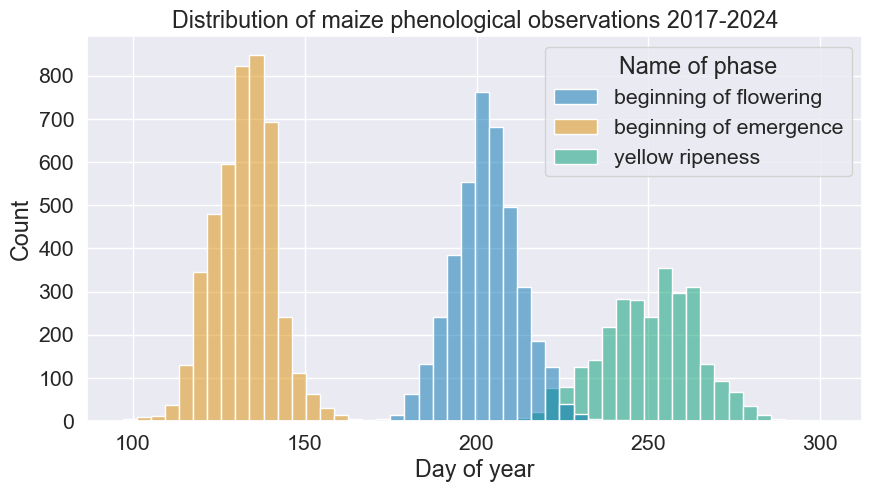

In [89]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.set(font_scale=1.4)
sns.histplot(data=main_stages_data, x="Jultag", hue="Name of phase", bins =50, ax=ax, palette = 'colorblind')
ax.set(xlabel='Day of year', ylabel='Count', title='Distribution of maize phenological observations 2017-2024')
fig.savefig('plots/phenological_obs_distribution.png', bbox_inches='tight')
#ax.tick_params(axis='both', which='major', labelsize=font_size)#axis='x', 
#ax.tick_params(axis='y', labelsize=10)

In [2]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()
tp=3
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.phase_list = ['beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.get_modelled_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.put_obs_data_in_input_array()
Maize_set.compare_modelled_observed()
Maize_set.get_X_y_for_ML('tas', cumulative=True, thinning_parameter=tp)
Maize_set.subsample_X_y(subsample_frac=0.8)
Maize_set.decision_tree(md=3)#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.ML_modelled_observed()

In [16]:
# data rows of csv file
coords = Maize_set.phen_data[['lat', 'lon', 'Stations_id']].drop_duplicates().values
# using the savetxt
# from the numpy module
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords.csv",
        coords,
        delimiter =", ",
        fmt ='% s')

In [12]:
phase_list = ['beginning of flowering', 'yellow ripeness']
training_means = []
for phase in phase_list:
    training_means.append(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].mean())
    print(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].count())
RMSE_ML_model(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)
#plot_error_distn(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)

9872
9872
Phase: beginning of flowering
RMSE for ML is 10.2
RMSE for model is 14.2
RMSE to training mean is 10.2
Phase: yellow ripeness
RMSE for ML is 15.3
RMSE for model is 27.5
RMSE to training mean is 13.7


In [ ]:
phase_list = ['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness']#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness', 'harvest']
#Maize_set.get_observed_dataset(phase_list=phase_list)
plotting.plot_obs_per_year(Maize_set.ds_observed, 'obs_per_year', phase_list=phase_list)
plotting.hist2d_locations(Maize_set.ds_observed.loc[2020].dropna()['lat'], Maize_set.ds_observed.loc[2020].dropna()['lon'], bin_num=5)
plotting.box_plot_modelled_observed(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), ['beginning of flowering', 'yellow ripeness'])

In [ ]:
tree_rules = tree.export_text(Maize_set.regr, feature_names=[f'Day {tp*i} cum. temp' for i in range(np.int64(np.floor(200/tp)))])
print(Maize_set.y_for_ML)
print(tree_rules)